In [2]:
!pip install scikit-plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
stop_words = stopwords.words('english')
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve

from sklearn import metrics
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,plot_roc_curve
from sklearn.model_selection import cross_val_score

import scikitplot as skplt

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
og_train_df=pd.read_csv('./sample_data/train.csv')
og_test_df=pd.read_csv('./sample_data/test.csv')


In [9]:
train_df=og_train_df.copy(deep=True)
test_df=og_test_df.copy(deep=True)

In [10]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [11]:
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [12]:
# As we can see the below null value for   title, author and text represents fake news

In [13]:
train_df.fillna('',inplace=True)

In [14]:
train_df[train_df.author==''].label.value_counts()

1    1931
0      26
Name: label, dtype: int64

In [15]:
train_df[train_df.title==''].label.value_counts()

1    558
Name: label, dtype: int64

In [16]:
train_df[train_df.text==''].label.value_counts()

1    39
Name: label, dtype: int64

#Let's create features for this pattern

For auhtor column, replace null with 'noauthor' keyword and nonnull values with 'authorpresent' keyword

For title and text replace null  values with 'notitleortext' keywords

In [17]:
def feature_engineer(text,author_flag=False):
    if author_flag:
        if text=='':
            return 'noauthor'
        else:
            return 'authorpresent'
    else:
        if text=='':
            return 'notitleortext'
        else:
            return text        

In [18]:
train_df['author']=train_df.author.apply(lambda x: feature_engineer(x,author_flag=True))

In [19]:
train_df['title']=train_df.title.apply(lambda x: feature_engineer(x))
train_df['text']=train_df.text.apply(lambda x: feature_engineer(x))

In [20]:
train_df[train_df.author=='authorpresent'].label.value_counts()

0    10361
1     8482
Name: label, dtype: int64

In [21]:
train_df[train_df.author=='noauthor'].label.value_counts()

1    1931
0      26
Name: label, dtype: int64

In [22]:
train_df.author.value_counts()

authorpresent    18843
noauthor          1957
Name: author, dtype: int64

In [23]:
train_df[train_df.title=='notitleortext'].label.value_counts()

1    558
Name: label, dtype: int64

In [24]:
train_df[train_df.text=='notitleortext'].label.value_counts()

1    39
Name: label, dtype: int64

In [25]:
#same processing in test data
test_df.fillna('',inplace=True)
test_df['author']=test_df.author.apply(lambda x: feature_engineer(x,author_flag=True))
test_df['title']=test_df.title.apply(lambda x: feature_engineer(x))
test_df['text']=test_df.text.apply(lambda x: feature_engineer(x))

In [26]:
#check for class imbalance on overall data. As we can see no class imbalance
train_df.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


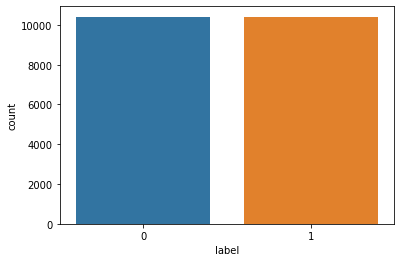

In [27]:
sns.countplot(train_df.label)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


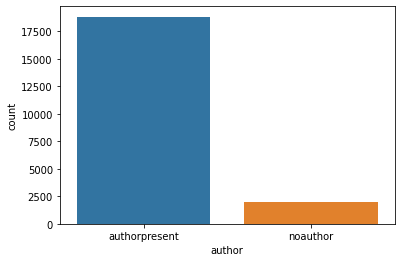

In [28]:
sns.countplot(train_df['author'])

In [29]:
#combine title,text and author to create comined text

In [30]:
train_df['combined_text']=train_df.title+' '+train_df.text+ ' '+ train_df.author
test_df['combined_text']=test_df.title+' '+test_df.text+ ' '+ test_df.author

In [31]:
train_df.loc[5000,'combined_text']

"These 12 Female Activists Are Making The World A Better Place Right Now These women are changing the world as we speak. Credit: Jiri Rezac \nWomen are typically at a disadvantage in nearly every country in the world, but just how much depends on that country’s culture. For some, it’s a struggle of equality in a variety of areas and for others it’s the immense problem of barely being seen as a person, let alone someone with rights. That’s why many women are facing these issues head on and working to make a huge difference in the world as we know it. \nThough many people hear about the female activists that made great strides to get their country to where it is today, people often don’t know about today’s activists. Read about the amazing women below to find out who is advocating for women and humanity around the world. Asieh Amini: Honor Killings Credit: Norsk Literatturfestival \nBorn in northern Iran, the region allowed women to own property, work on farms, and wield social power. Am

In [32]:
def clean_text(text_val):
    text = text_val
    text = text.lower()
    text=text.replace('“','').replace('”','').replace('’','')
    text = re.sub('\n', '', text)
    text=''.join([ele for ele in text if ele not in string.punctuation])
    return text


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


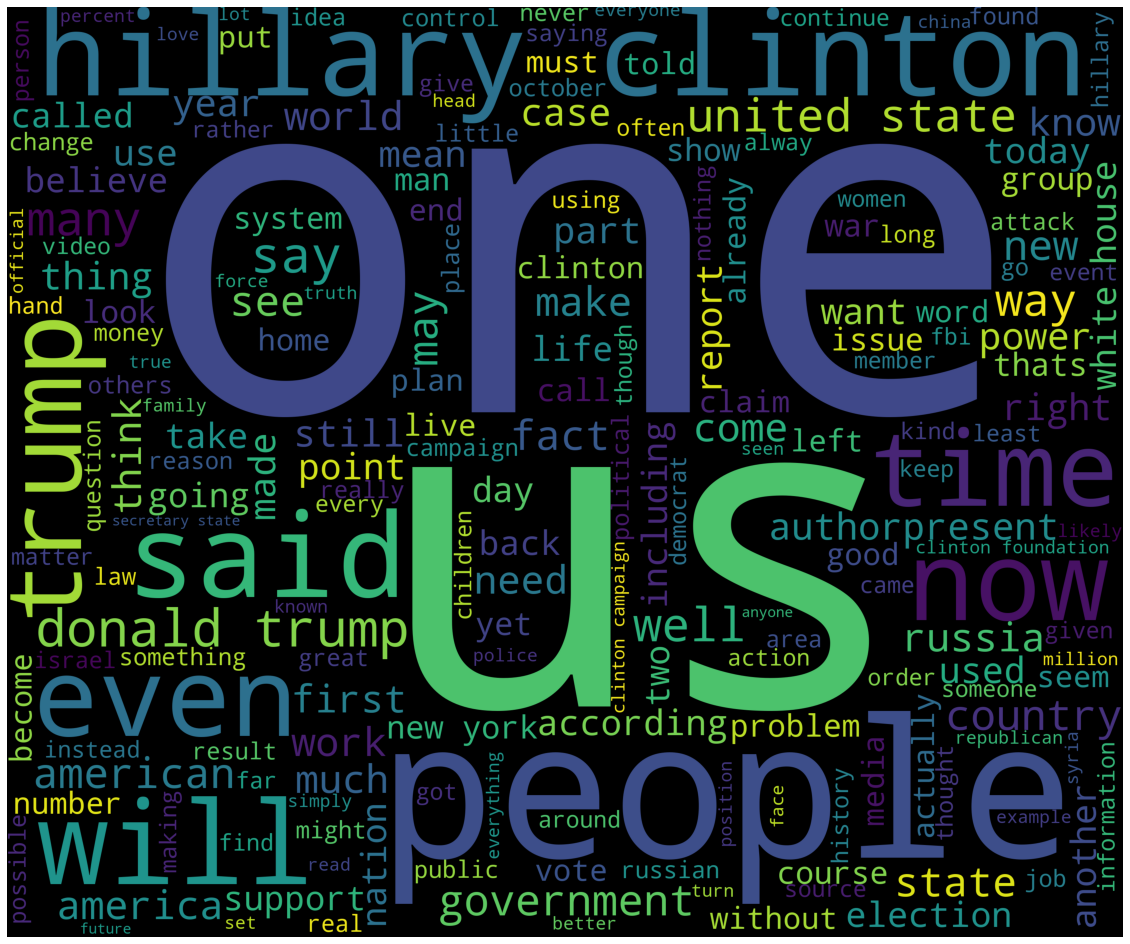

In [ ]:
fake_news_df=train_df[train_df['label']==1]
fake_news_df['combined_text']=fake_news_df.combined_text.apply(lambda x : clean_text(x))
words = ' '.join(fake_news_df['combined_text'])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      width=3000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


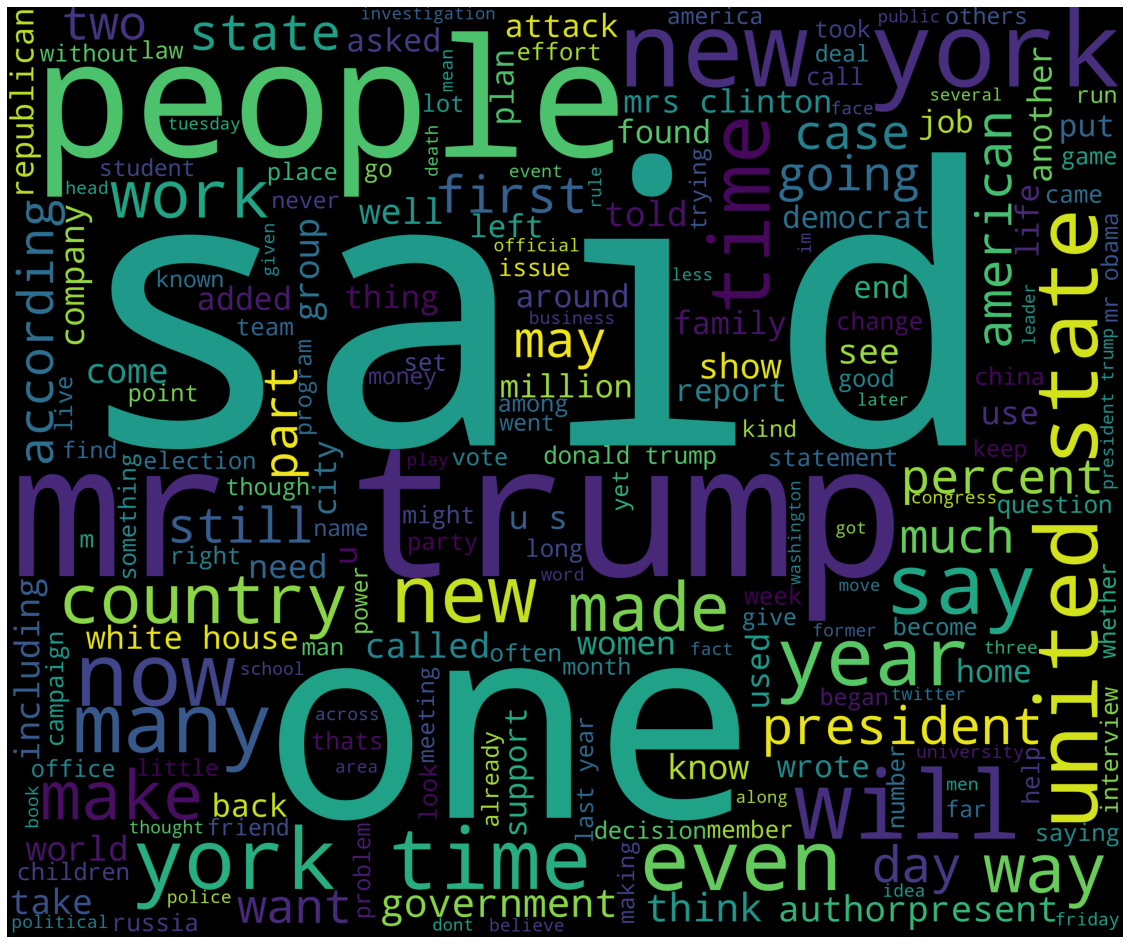

In [ ]:
nonfake_news_df=train_df[train_df['label']==0]
nonfake_news_df['combined_text']=nonfake_news_df.combined_text.apply(lambda x : clean_text(x))
words = ' '.join(nonfake_news_df['combined_text'])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      width=3000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [33]:
#processing of text
lemmatizer = WordNetLemmatizer()
def preprocess_text(text_val):
    text=clean_text(text_val)
    text=' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)  if len(word)>2 and (not word.isdigit()) and word not in stop_words])
    return text


In [34]:
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
train_df['combined_text']=train_df.combined_text.apply(lambda x: preprocess_text(x))
test_df['combined_text']=test_df.combined_text.apply(lambda x: preprocess_text(x))


In [ ]:
train_df.to_csv('train_transformed_data.csv',index=False)
test_df.to_csv('test_transformed_data.csv',index=False)

In [4]:
!pip install sister

     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 19.7MB 251kB/s 
  Created wheel for sister: filename=sister-0.1.10-cp37-none-any.whl size=5392 sha256=b94492c795cb0a5b1688e41bcd90d0ab767d63d353385ebe1f2f17689b3b55d6
  Stored in directory: /root/.cache/pip/wheels/69/8d/01/c066cc2e5c98891fc1af11f393882ee718b6026f3f8b0623b0
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3093265 sha256=b1213b70394f4229076f9c9ac8fc0a37b0594ecc8d028da621d206f86948d320
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built sister fasttext


In [36]:
import sister
mean_embedding = sister.MeanEmbedding(lang="en",)

sentences = "I am a dog. I want be a cat."
vectors = mean_embedding(sentences)

Loading model...


In [37]:
X_embedded=train_df.combined_text.apply(lambda x:  mean_embedding(x))

In [38]:
X_embedded=[list(ele) for ele in X_embedded.values]

In [39]:
import numpy as np
X_embedded=np.array(X_embedded)

In [40]:
#Split data into train and test set
X_train,X_test,y_train,y_test = train_test_split(X_embedded,train_df.label,test_size=0.2, random_state=42,stratify=train_df.label)

In [41]:
X_train

array([[ 0.08830593,  0.00396661,  0.07459939, ..., -0.10126919,
        -0.03039641, -0.08476835],
       [ 0.08757474, -0.03777444,  0.16650037, ..., -0.074514  ,
        -0.08838256, -0.09282401],
       [ 0.12897219, -0.0537314 ,  0.12857054, ..., -0.11090336,
        -0.06245298, -0.1254173 ],
       ...,
       [ 0.1432662 , -0.05149906,  0.14718883, ..., -0.04547802,
        -0.08565287, -0.07733669],
       [ 0.11293815, -0.03894935,  0.07467955, ..., -0.09759257,
        -0.05701788, -0.08813976],
       [ 0.06702637,  0.07685271,  0.09855013, ..., -0.04089105,
        -0.08128469, -0.08502387]], dtype=float32)

In [ ]:
lr=LogisticRegression()
param_grid = {
              "C": [0.001,0.01,0.1,0.5,0.15,1,10,],
              "solver": ['newton-cg','lbfgs','liblinear','sag','saga'],
              }

CV_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv= 5)
CV_lr.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search fail

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 0.15, 1, 10],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print("Best Parameters:")
print(CV_lr.best_params_)
print(CV_lr.best_score_)


Best Parameters:
{'C': 10, 'solver': 'sag'}
0.8605769230769231


In [ ]:
lr_predictions=CV_lr.predict(X_test)
#We can see that we got a f1-score of 86 for negative class using logistic regression
print(confusion_matrix(y_test,lr_predictions))
print(classification_report(y_test,lr_predictions))


[[1813  264]
 [ 312 1771]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2077
           1       0.87      0.85      0.86      2083

    accuracy                           0.86      4160
   macro avg       0.86      0.86      0.86      4160
weighted avg       0.86      0.86      0.86      4160



In [ ]:
#store recall and f1score for class 0 i.e negative sentiment
metrics_value=precision_recall_fscore_support(y_test, lr_predictions, average=None,labels=[0,1])

recall_for_class_1_logistic_regression=round(metrics_value[1][1],2)
f1score_for_class_1_logistic_regression=round(metrics_value[2][1],2)


In [46]:
svc_model=SVC(probability=True,kernel='poly')
svc_model.fit(X_train,y_train)
predictions_svc=svc_model.predict(X_test)
#print confusion matrix and classification report
print(confusion_matrix(y_test,predictions_svc))

print(classification_report(y_test,predictions_svc))


[[1854  223]
 [ 286 1797]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2077
           1       0.89      0.86      0.88      2083

    accuracy                           0.88      4160
   macro avg       0.88      0.88      0.88      4160
weighted avg       0.88      0.88      0.88      4160



In [ ]:
metrics_value_svc=precision_recall_fscore_support(y_test, predictions_svc, average=None,labels=[0,1])

recall_for_class_1_svc=round(metrics_value_svc[1][1],2)
f1score_for_class_1_svc=round(metrics_value_svc[2][1],2)


In [ ]:
dtree=DecisionTreeClassifier(random_state=42)
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [10, 20, 40],
              "max_depth": range(2,30),
              "min_samples_leaf": range(2,40),
              "max_leaf_nodes": range(2,20),
              }

CV_dtree = RandomizedSearchCV(estimator=dtree, param_distributions=param_grid, cv= 6)
CV_dtree.fit(X_train, y_train)

print("Best Parameters:")
print(CV_dtree.best_params_)
print(CV_dtree.best_score_)


Best Parameters:
{'min_samples_split': 40, 'min_samples_leaf': 11, 'max_leaf_nodes': 16, 'max_depth': 20, 'criterion': 'gini'}
0.7066698629356987


In [ ]:
final_dtree_model=DecisionTreeClassifier(min_samples_split= 40, min_samples_leaf=11, max_leaf_nodes= 16, max_depth=20,criterion='gini')
final_dtree_model.fit(X_train,y_train)
pred_dtree=final_dtree_model.predict(X_test)
print(confusion_matrix(y_test,pred_dtree))

print(classification_report(y_test,pred_dtree))


[[1462  615]
 [ 644 1439]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      2077
           1       0.70      0.69      0.70      2083

    accuracy                           0.70      4160
   macro avg       0.70      0.70      0.70      4160
weighted avg       0.70      0.70      0.70      4160



In [ ]:
metrics_value_dtree=precision_recall_fscore_support(y_test, pred_dtree, average=None,labels=[0,1])

recall_for_class_0_dtree=round(metrics_value_dtree[1][1],2)
f1score_for_class_0_dtree=round(metrics_value_dtree[2][1],2)


In [ ]:
RF_model=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [20,30,40,50,100,125,150,175,200,225,250,275],
    'max_depth' : range(2,500),
    'criterion':["gini","entropy"],
    "min_samples_leaf": range(1,20),
    "max_leaf_nodes": range(2,20),
    'max_features':["auto", "sqrt", "log2"]
}

CV_rfc = RandomizedSearchCV(estimator=RF_model, param_distributions=param_grid, cv= 6,)
CV_rfc.fit(X_train, y_train)

print("Best Parameters:")
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)


Best Parameters:
{'n_estimators': 175, 'min_samples_leaf': 6, 'max_leaf_nodes': 16, 'max_features': 'sqrt', 'max_depth': 301, 'criterion': 'entropy'}
0.771573797631277


In [ ]:
rc_predictions=CV_rfc.predict(X_test)

#print confusion matrix and classification report
print(confusion_matrix(y_test,rc_predictions))

print(classification_report(y_test,rc_predictions))


[[1612  465]
 [ 510 1573]]
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2077
           1       0.77      0.76      0.76      2083

    accuracy                           0.77      4160
   macro avg       0.77      0.77      0.77      4160
weighted avg       0.77      0.77      0.77      4160



In [ ]:
#store recall and f1score for class 0 i.e negative sentiment
metrics_value_rf=precision_recall_fscore_support(y_test, rc_predictions, average=None,labels=[0,1])

recall_for_class_0_rf=round(metrics_value_rf[1][1],2)
f1score_for_class_0_rf=round(metrics_value_rf[2][1],2)


In [51]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting=GradientBoostingClassifier(n_estimators=400,random_state=42)
gradient_boosting.fit(X_train, y_train)



GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [53]:

gdb_prediction=gradient_boosting.predict(X_test)

#print confusion matrix and classification report
print(confusion_matrix(y_test,gdb_prediction))
print(classification_report(y_test,gdb_prediction))


[[1829  248]
 [ 301 1782]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2077
           1       0.88      0.86      0.87      2083

    accuracy                           0.87      4160
   macro avg       0.87      0.87      0.87      4160
weighted avg       0.87      0.87      0.87      4160



In [44]:
#store recall and f1score for class 0 i.e negative sentiment
metrics_value_gdb=precision_recall_fscore_support(y_test, gdb_prediction, average=None,labels=[0,1])

recall_for_class_1_gdb=round(metrics_value_gdb[1][1],2)
f1score_for_class_1_gdb=round(metrics_value_gdb[2][1],2)


Conclusion:

As we can see from traditional ML Algorithms, SVC is performing best with F1 score as 88 percent for both the classes